In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold

In [3]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [4]:
df = pd.read_csv('course_lead_scoring.csv')

In [5]:
df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [8]:
# Assuming df is your DataFrame
for col in df.columns:
    if df[col].dtype == 'object':  # Categorical feature
        df[col] = df[col].fillna('NA')
    else:  # Numerical feature
        df[col] = df[col].fillna(0.0)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [21]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [11]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [12]:
numerical = ['number_of_courses_viewed', 'annual_income','interaction_count','lead_score']

categorical = ['lead_source','industry','employment_status','location']

In [13]:
from sklearn.metrics import roc_auc_score


best_auc = 0
best_var = None

for var in numerical:
    scores = df_train[var]
    auc = roc_auc_score(y_train, scores)
    
    # Invert if negatively correlated
    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)
    
    print(f"AUC for {var}: {auc:.4f}")
    
    if auc > best_auc:
        best_auc = auc
        best_var = var

print(f"\n The numerical variable with the highest AUC is: **{best_var}** with AUC = {best_auc:.4f}")


AUC for number_of_courses_viewed: 0.7636
AUC for annual_income: 0.5520
AUC for interaction_count: 0.7383
AUC for lead_score: 0.6145

🔍 The numerical variable with the highest AUC is: **number_of_courses_viewed** with AUC = 0.7636


## Question 2: Training the model

In [14]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [15]:
dv, model = train(df_train, y_train)

In [16]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [17]:
y_pred = predict(df_val, dv, model)

In [18]:
auc = roc_auc_score(y_val, y_pred)

In [20]:
round(auc,3)

0.817

## Question 3: Precision and Recall

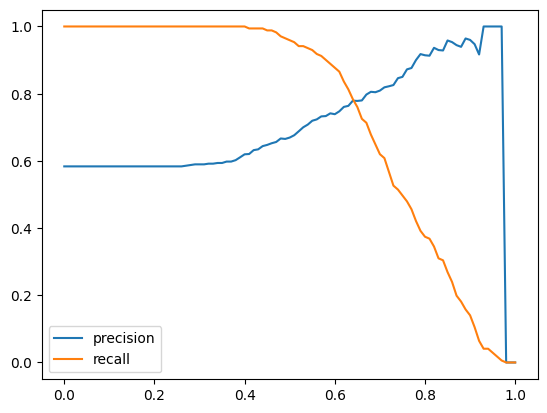

In [26]:
scores = []

thresholds = thresholds = np.arange(0.0, 1.01, 0.01)#np.linspace(0, 1.0, 101)


for t in thresholds:
    y_val_binary = (y_pred >= t).astype(int)

    # Calculate Precision and Recall
    p = precision_score(y_val, y_val_binary, zero_division=0)
    r = recall_score(y_val, y_val_binary)

    scores.append((t, p, r))

columns = ["threshold", "precision", "recall"]
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()



In [35]:
# Absolute difference between precision and recall
df_scores["diff"] = np.abs(df_scores["precision"] - df_scores["recall"])

# Find the threshold where this difference is minimal
intersection_threshold = (
    df_scores.query("precision != 0 & recall != 0")
    .sort_values(by="diff")
    .head(1)["threshold"]
    .values[0]
)

print(f"Precision and recall curves intersect at threshold: {intersection_threshold:.3f}")

Precision and recall curves intersect at threshold: 0.640


## Question 4: F1 score

In [30]:
thresholds = np.arange(0.0, 1.01, 0.01)
scores = []

for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    p = precision_score(y_val, y_pred_binary, zero_division=0)
    r = recall_score(y_val, y_pred_binary)
    
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    
    scores.append((t, p, r, f1))

# Create DataFrame
df_f1 = pd.DataFrame(scores, columns=["threshold", "precision", "recall", "f1"])

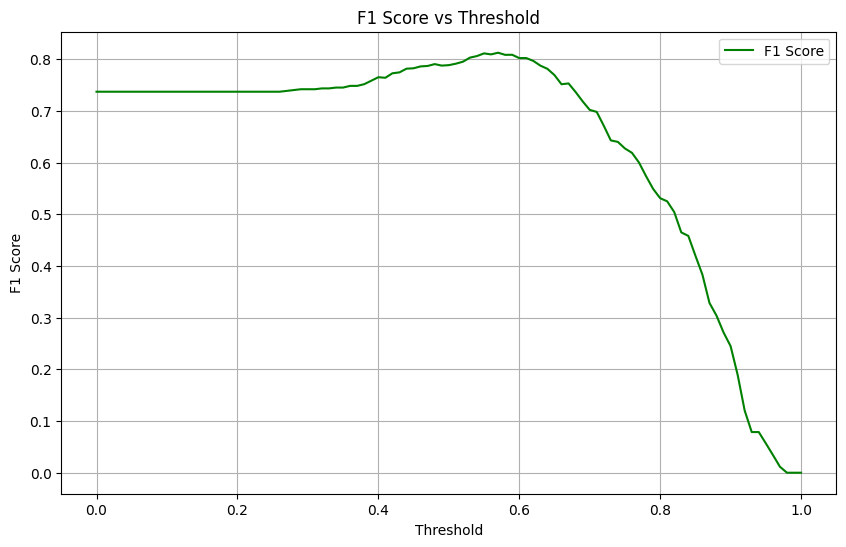

In [31]:
# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(df_f1["threshold"], df_f1["f1"], label="F1 Score", color='green')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.legend()
plt.show()



In [34]:
# Find threshold where F1 is maximal
best_f1_row = df_f1.loc[df_f1["f1"].idxmax()]
best_threshold = best_f1_row["threshold"]
best_f1 = best_f1_row["f1"]

print(f"Max F1 Score: {best_f1:.4f} at threshold: {best_threshold:.2f}")

Max F1 Score: 0.8125 at threshold: 0.57


## Question 5: 5-Fold CV

In [55]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [56]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [42]:

!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [50]:
from tqdm.auto import tqdm

In [52]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.822 +- 0.036
C=0.01 0.822 +- 0.036
C=0.1 0.822 +- 0.036
C=0.5 0.822 +- 0.036
C=1 0.822 +- 0.036
C=5 0.822 +- 0.036
C=10 0.822 +- 0.036


In [53]:
scores

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]

In [65]:
std = np.std(scores)

print(f"Standard deviation (population): {std:.4f}")

Standard deviation (population): 0.0358


## Question 6: Hyperparameter Tuning

In [63]:
n_splits = 5

HPT_results = {}

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Calculate mean and std for this C
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)

    HPT_results[C] = {"mean_auc": mean_auc, "std_auc": std_auc}

    print(f"C = {C:<8.6f} | Mean AUC: {mean_auc:.3f} | Std: {std_auc:.3f}")

  0%|          | 0/3 [00:00<?, ?it/s]

C = 0.000001 | Mean AUC: 0.560 | Std: 0.024
C = 0.001000 | Mean AUC: 0.867 | Std: 0.029
C = 1.000000 | Mean AUC: 0.822 | Std: 0.036


In [64]:
# Convert results to DataFrame for easier sorting and viewing
df_hpt = pd.DataFrame([
    {"C": C, 
     "mean_auc": round(res["mean_auc"], 3), 
     "std_auc": round(res["std_auc"], 3)}
    for C, res in HPT_results.items()
])

# Apply the selection rules:
# 1. Highest mean_auc
# 2. If tie, lowest std_auc
# 3. If still tie, smallest C
df_hpt_sorted = df_hpt.sort_values(by=["mean_auc", "std_auc", "C"], ascending=[False, True, True])

best_C = df_hpt_sorted.iloc[0]["C"]

print("\nCross-validation results:")
print(df_hpt)

print(f"\n🏆 Best C: {best_C} with mean AUC: {df_hpt_sorted.iloc[0]['mean_auc']:.3f} "
      f"and std: {df_hpt_sorted.iloc[0]['std_auc']:.3f}")



Cross-validation results:
          C  mean_auc  std_auc
0  0.000001     0.560    0.024
1  0.001000     0.867    0.029
2  1.000000     0.822    0.036

🏆 Best C: 0.001 with mean AUC: 0.867 and std: 0.029
